In [1]:
%pip freeze > requirements.txt

/bin/bash: /home/mplockhart/miniconda3/envs/transformer/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Note: you may need to restart the kernel to use updated packages.


# Building a transformer model
All of the information can be found here:  
https://machinelearningmastery.com/wp-content/uploads/2023/01/building_transformer_models_with_attention_mini_course.pdf?__s=0r0s1e8vtea8nzhf01f7&utm_source=drip&utm_medium=email&utm_campaign=AFML+Mini-Course&utm_content=Building+Transformer+Models+with+Attention+%28crash-course%29

# Modules
All modules will be loaded here with the lesson numbers for additional ones.

## Installing more complicated modules
### TensorFlow
This was installed using the `pip` instuctions here https://www.tensorflow.org/install/pip#windows-wsl2

## Lesson 1
As you are building a neural machine translator, you need data for training and testing. Let's build a sentence-based English-to-French translator. There are many resources on the Internet. An example would be the user-contributed data for the flash card app Anki. You can download some data files at https://ankiweb.net/shared/decks/french. The data file would be a ZIP file containing a SQLite database file, from which you can extract the English-French sentence pairs.

However, you may find it more convenient to have a text file version, which you can find it at https://www.manythings.org/anki/. Google hosts a mirror of this file as well, which we will be using. The code below will download the compressed data file and extract it:

In [55]:
# day 1
import pathlib
import tensorflow as tf

# day 2
import pickle
import random
import re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt

# day 3
from tensorflow.keras.layers import TextVectorization


In [3]:
# download dataset provided by Anki: https://www.manythings.org/anki/
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True,
)
# show where the file is located now
text_file = pathlib.Path(text_file).parent / "fra.txt"
print(text_file)

/home/mplockhart/.keras/datasets/fra.txt


### Your Task
Try to run the above code and open the file extracted. You should verify that the format of each line is like the above. In the next lesson, you will process this file and prepare the dataset suitable for training and testing.

The data file will be a plaintext file named fra.txt. Its format would be lines of:

`<english sentence><tab character><french sentence>`

In [4]:
# exploring the file
with open(text_file, 'r') as file:
    text_pairs = file.readlines()

In [5]:
# print the main details
print(f"The length of the file is: {len(text_pairs)}.")

# make sure the lines are in the format "words \t words \n"
# List comprehension to check if the split at '\t' gives us an output of 2
file_check = [line for line in text_pairs if len(line.split('\t')) != 2]
if len(file_check) != 0:
    print("There is an issue. Here are the problems:")
    print(f"{file_check}")
else:
    print("The file looks correctly formatted.")

The length of the file is: 167130.
The file looks correctly formatted.


# Lesson 2
Just like all NLP tasks, you need to normalize the text before you use it. French letters
have accents which would be represented as Unicode characters, but such representation is
not unique in Unicode. Therefore, you will convert the string into NFKC (compatibility and
composition normal form).  

Next, you will tokenize the sentences. Each word should be a separate token as well as
each punctuation mark. However, the punctuation used in contractions such as don’t, va-t-il,
or c’est are not separated from the words. Also, convert everything into lowercase in the
expectation that this will reduce the number of distinct words in the vocabulary.  

Normalization and tokenization can go a lot deeper, such as subword tokenization,
stemming, and lemmatization. But to keep things simple, you do not do these in this project.  

Starting from scratch, the code to normalize the text is below. You will use the Python
module unicodedata to convert a Unicode string into NFKC normal form. Then you will use
regular expression to add space around punctuation marks. Afterward, you will wrap the
French sentences (i.e., the target language) with sentinels [start] and [end]. You will see the
purpose of the sentinels in later lessons.

In [6]:
def normalize(line):
    """Normalize a line of text and split into two at the tab character.""" 
    line = unicodedata.normalize("NFKC", line.strip().lower())
    line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
    line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
    line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
    eng, fra = line.split("\t")
    fra = "[start] " + fra + " [end]"
    return eng, fra



In [7]:
# normalize each line and separate into English and French
with open(text_file) as fp:
    text_pairs = [normalize(line) for line in fp]

# print some samples
for _ in range(5):
    print(random.choice(text_pairs))

# export the text pairs to a pickle file
with open("text_pairs.pickle", "wb") as fp:
    pickle.dump(text_pairs, fp)


("it's going to be very cold tonight .", '[start] il va faire très froid ce soir . [end]')
('i need to borrow your pen .', "[start] il me faut t'emprunter ton stylo . [end]")
('everybody was stunned .', '[start] tout le monde a été abasourdi . [end]')
('a picture is worth a thousand words .', '[start] une image vaut mille mots . [end]')
('would you like a cup of coffee ?', '[start] voudrais-tu une tasse de café  ?  [end]')


In [9]:
# open file pairs from pickle file
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
    eng_tok, fra_tok = eng.split(), fra.split()
    eng_maxlen = max(eng_maxlen, len(eng_tok))
    fra_maxlen = max(fra_maxlen, len(fra_tok))
    eng_tokens.update(eng_tok)
    fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")

Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


### It is worth visualising the data
It is always worth visualising the data  to get more of a feel of what it looks like.  
Thye longest set of tokens is 51 and 60 but how frequent is that?

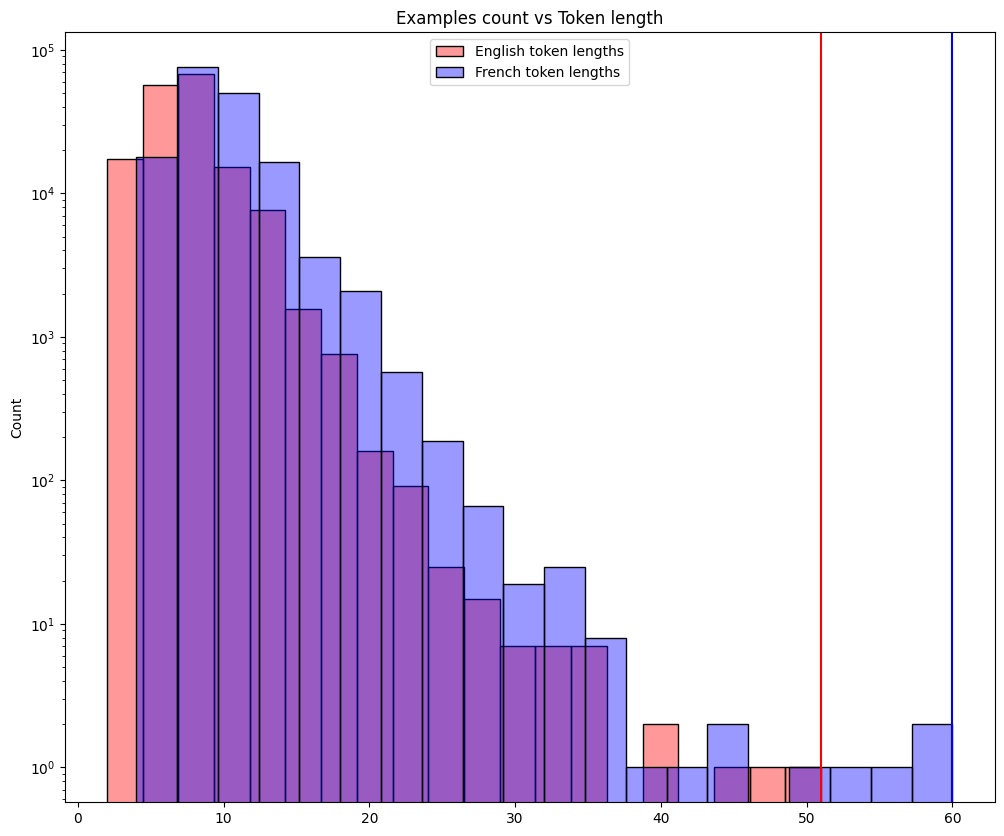

In [51]:
# counting the lengths of the tokens
# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, _ in text_pairs]
fr_lengths = [len(fra.split()) for _, fra in text_pairs]

ALPHA=0.4
fig, ax = plt.subplots(figsize=(12, 10))
sns.histplot(en_lengths, bins=20, legend=True, alpha=ALPHA, color='red', log_scale=(False,True))
sns.histplot(fr_lengths, bins=20, legend=True, alpha=ALPHA, color='blue', log_scale=(False,True))
plt.legend(['English token lengths', 'French token lengths'])
# plt.hist(en_lengths, label="en", color="red", alpha=0.33)
# plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
# plt.yscale("log")     # sentence length fits Benford"s law
plt.ylim(plt.ylim())  # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.title("Examples count vs Token length")
plt.show()

# Lesson 3
Hi, in this lesson, you will learn to create a dataset object that helps training the transformer model.
In the previous lesson, you cleaned up the sentences, but they are still text. Neural networks can handle only numbers. One way to convert the text into numbers is through vectorization. What this means is to transform the tokens from the text into an integer. Hence a sentence with n tokens (words) will become a vector of n integers.

You can build your own vectorizer. Simply build a mapping table of each unique token to a unique integer. When it is used, you look up the token one by one in the table and return the integers in the form of a vector.

In Keras, you have TextVectorization layer to save us the effort of building a vectorizer. It supports padding, i.e., integer 0 is reserved to mean "empty." This is useful when you give a sentence of m < n tokens but want the vectorizer always to return a fixed length n vector.

You will first split the sentence pair into training, validation, and testing sets as you need them for the model training. Then, create a TextVectorization layer and adapt it to the training set only (because you should not peek into the validation or testing dataset until the model training is completed).

In [57]:
# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
    text_pairs = pickle.load(fp)

# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]

### More information

Note that the parameter max_tokens to TextVectorization object can be omitted to let the vectorizer figure it out. But if you set them to a value smaller than the total vocabulary (such as this case), you limit the the vectorizer to learn only the more frequent words and make the rare words as out-of-vocabulary (OOV). This may be useful to skip the words of little value or with spelling mistakes. You also fix the output length of the vectorizer. We assumed that a sentence should have no more than 20 tokens in the above.

The next step would be to make use of the vectorizer and create a TensorFlow Dataset object. This will be helpful in your later steps to train our model.

More info can be found on the TensorFlow site:  
https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

In [78]:
# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20

# Create vectorizer
# Now that the vocab layer has been created, call `adapt` on the
# text-only dataset to create the vocabulary. You don't have to batch,
# but for large datasets this means we're not keeping spare copies of
# the dataset.
eng_vectorizer = TextVectorization(
    max_tokens=vocab_size_en,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length,
)
fra_vectorizer = TextVectorization(
    max_tokens=vocab_size_fr,
    standardize=None,
    split="whitespace",
    output_mode="int",
    output_sequence_length=seq_length + 1
)


In [79]:
# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)

In [81]:
# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
    data = {
        "train": train_pairs,
        "val":   val_pairs,
        "test":  test_pairs,
        "engvec_config":  eng_vectorizer.get_config(),
        "engvec_weights": eng_vectorizer.get_weights(),
        "fravec_config":  fra_vectorizer.get_config(),
        "fravec_weights": fra_vectorizer.get_weights(),
    }
    pickle.dump(data, fp)

In [84]:
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
    data = pickle.load(fp)

# pull the data from the dictionary
train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"]   # not used
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])

In [85]:
# set up Dataset object
def format_dataset(eng, fra):
    eng = eng_vectorizer(eng)
    fra = fra_vectorizer(fra)
    source = {"encoder_inputs": eng,
              "decoder_inputs": fra[:, :-1]}
    target = fra[:, 1:]
    return (source, target)

def make_dataset(pairs, batch_size=64):
    # aggregate sentences using zip(*pairs)
    eng_texts, fra_texts = zip(*pairs)
    # convert them into list, and then create tensors
    dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
    return dataset.shuffle(2048) \
                  .batch(batch_size).map(format_dataset) \
                  .prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [91]:
train_ds.take(10)

<_TakeDataset element_spec=({'encoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), 'decoder_inputs': TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>

In [98]:
# test the dataset
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
    print(f"targets.shape: {targets.shape}")
    print(f"targets[0]: {targets[0]}")

inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [ 12 140 208  11  74 106  59 459   2   0   0   0   0   0   0   0   0   0
   0   0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2   15   11 1852   96   39  559   13  425   24  420    4    3    0
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [  15   11 1852   96   39  559   13  425   24  420    4    3    0    0
    0    0    0    0    0    0]


2023-04-19 20:29:32.615366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_18' with dtype int64
	 [[{{node Placeholder/_18}}]]
2023-04-19 20:29:32.615916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_14' with dtype int64
	 [[{{node Placeholder/_14}}]]
2023-04-19 20:29:32.653841: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache(